# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)
5. [Other data](#Other-data)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [2]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [3]:
from roc_results import results #results_even_data as results

df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_test = lob.load_prepared_data(s, length=None)
    dfs[s] = d
    dfs_test[s] = d_test

Len of data for  10795 is 7492
Training set length for 10795: 5994
Testing set length for 10795: 1498
Len of data for  12098 is 5986
Training set length for 12098: 4789
Testing set length for 12098: 1197
Len of data for  11618 is 6320
Training set length for 11618: 5056
Testing set length for 11618: 1264
Len of data for  2051 is 6057
Training set length for 2051: 4846
Testing set length for 2051: 1211
Len of data for  4481 is 6505
Training set length for 4481: 5204
Testing set length for 4481: 1301
Len of data for  3107 is 5799
Training set length for 3107: 4640
Testing set length for 3107: 1159
Len of data for  1243 is 8421
Training set length for 1243: 6737
Testing set length for 1243: 1684
Len of data for  11234 is 6416
Training set length for 11234: 5133
Testing set length for 11234: 1283
Len of data for  1229 is 7478
Training set length for 1229: 5983
Testing set length for 1229: 1495
Len of data for  4218 is 7268
Training set length for 4218: 5815
Testing set length for 4218: 145

Len of data for  9086 is 13919
Training set length for 9086: 11136
Testing set length for 9086: 2783
Len of data for  1472 is 14163
Training set length for 1472: 11331
Testing set length for 1472: 2832
Len of data for  10887 is 14032
Training set length for 10887: 11226
Testing set length for 10887: 2806
Len of data for  10166 is 15876
Training set length for 10166: 12701
Testing set length for 10166: 3175
Len of data for  2813 is 13183
Training set length for 2813: 10547
Testing set length for 2813: 2636
Len of data for  9269 is 15689
Training set length for 9269: 12552
Testing set length for 9269: 3137
Len of data for  9062 is 17551
Training set length for 9062: 14041
Testing set length for 9062: 3510
Len of data for  9067 is 15554
Training set length for 9067: 12444
Testing set length for 9067: 3110
Len of data for  9266 is 13837
Training set length for 9266: 11070
Testing set length for 9266: 2767
Len of data for  9064 is 17676
Training set length for 9064: 14141
Testing set length

In [4]:
stocks = [s for s in stocks if len(dfs[s]) > 8000]
print(len(stocks))

53


In [5]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc

,stock,roc_area
50,11946,0.588350
45,4320,0.584180
7,2651,0.579819
22,1907,0.579329
52,11869,0.573567
18,7858,0.571631
49,12255,0.569709
48,1431,0.568177
40,3879,0.565911
33,9268,0.565809


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

In [7]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
pearson_corrs1 = []
pearson_corrs2 = []
bid_len = []
ask_len = []
from scipy.stats import pearsonr
for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())
    p1, p2 = pearsonr(dfs[s]['queue_imbalance'], dfs[s]['mid_price'])
    pearson_corrs1.append(p1)
    pearson_corrs2.append(p2)
    max_len_bid = 0
    max_len_ask = 0
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])

    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['pearson_corr1'] = pearson_corrs1
df_summary['pearson_corr2'] = pearson_corrs2
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.58]


,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
11946,0.58835,17693.761818,17930.643211,-236.881393,206.1,183.6,22.5,0.170185,0.048886,0.000009,939,812
4320,0.58418,592.832214,625.114060,-32.281846,3574.0,2920.0,654.0,1.983904,0.040309,0.000094,879,933


In [8]:
df_summary.sort_values(by='roc_area')

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
9058,0.526106,3199.069121,3351.226893,-152.157772,2021.50,1764.00,257.50,0.762578,-0.017721,4.808024e-02,1916,1920
13003,0.533144,2502.155624,3105.452365,-603.296740,447.90,367.80,80.10,0.246523,0.033755,5.974102e-04,1128,1073
9061,0.534195,6568.618150,7020.150333,-451.532183,730.20,662.30,67.90,0.169701,0.017832,3.621991e-02,2271,1823
9074,0.535167,3957.187347,3740.050175,217.137173,2240.50,1977.00,263.50,0.680803,-0.026772,4.154976e-03,1208,1085
11244,0.538585,4195.989583,4241.678131,-45.688548,355.50,321.70,33.80,0.119144,0.043225,3.069762e-07,3028,2576
9270,0.538618,3570.702326,4266.242844,-695.540519,2297.00,2071.00,226.00,0.625537,0.031744,7.880151e-04,1326,1433
9064,0.539293,28743.289513,27628.562902,1114.726611,80.88,72.70,8.18,0.024897,-0.001260,8.808812e-01,2204,1882
9266,0.541688,2759.120596,2836.700723,-77.580126,1692.50,1429.50,263.00,0.758220,0.045207,1.952695e-06,1352,1435
9067,0.543987,1036.968258,1035.869897,1.098361,3470.00,3109.50,360.50,1.064730,0.024827,5.610513e-03,1278,1739
9062,0.544367,941.166085,958.608717,-17.442632,3405.00,2937.00,468.00,1.020939,0.011009,1.921049e-01,2517,2708


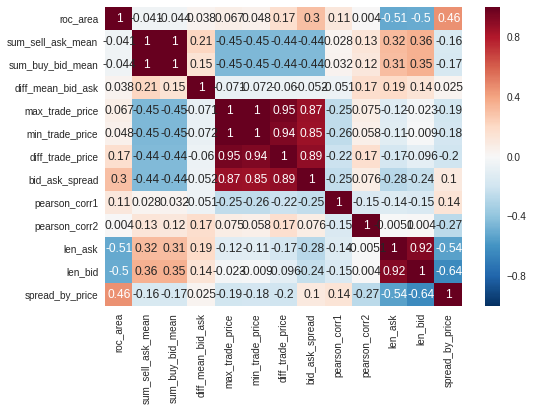

In [9]:
df_summary['spread_by_price'] = df_summary['bid_ask_spread'] / df_summary['diff_trade_price']
sns.heatmap(df_summary.corr(), annot=True)

In [10]:
df_summary[['roc_area', 'diff_mean_bid_ask', 'diff_trade_price', 
            'max_trade_price', 'min_trade_price',
            'spread_by_price']].sort_values(by='spread_by_price')

,roc_area,diff_mean_bid_ask,diff_trade_price,max_trade_price,min_trade_price,spread_by_price
9063,0.551662,524.370832,83.05,510.10,427.05,0.001124
9069,0.548624,1431.670887,61.15,308.00,246.85,0.001629
3161,0.559038,-1236.489997,87.00,419.80,332.80,0.001659
9269,0.545424,-263.420650,60.10,403.05,342.95,0.001743
9086,0.547627,-550.145564,36.10,244.20,208.10,0.001776
5836,0.562721,-28.882488,711.00,3090.00,2379.00,0.001899
9062,0.544367,-17.442632,468.00,3405.00,2937.00,0.002181
9061,0.534195,-451.532183,67.90,730.20,662.30,0.002499
9265,0.549941,-8.307530,396.00,3559.50,3163.50,0.002512
10166,0.546252,10.428470,489.50,3454.50,2965.00,0.002558


In [11]:
df_summary['spread_by_price_diff'] = df_summary['diff_trade_price'] *  df_summary['bid_ask_spread']
df_summary.corr()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,spread_by_price,spread_by_price_diff
roc_area,1.000000,-0.041400,-0.044389,0.038200,0.066742,0.047853,0.167151,0.301285,0.112606,0.003963,-0.514917,-0.502425,0.456053,0.293361
sum_sell_ask_mean,-0.041400,1.000000,0.997950,0.211400,-0.451122,-0.449055,-0.438021,-0.439389,0.028296,0.126480,0.316461,0.357862,-0.163018,-0.341597
sum_buy_bid_mean,-0.044389,0.997950,1.000000,0.148420,-0.451810,-0.449635,-0.439264,-0.441163,0.031992,0.116531,0.307521,0.352974,-0.166589,-0.343823
diff_mean_bid_ask,0.038200,0.211400,0.148420,1.000000,-0.070747,-0.072020,-0.059899,-0.052038,-0.051347,0.174736,0.193535,0.139116,0.025183,-0.027530
max_trade_price,0.066742,-0.451122,-0.451810,-0.070747,1.000000,0.998514,0.953902,0.865603,-0.253201,0.075476,-0.120602,-0.022572,-0.188538,0.833952
min_trade_price,0.047853,-0.449055,-0.449635,-0.072020,0.998514,1.000000,0.936131,0.852827,-0.257259,0.057944,-0.109805,-0.009038,-0.184788,0.815978
diff_trade_price,0.167151,-0.438021,-0.439264,-0.059899,0.953902,0.936131,1.000000,0.888982,-0.217102,0.167942,-0.173524,-0.095890,-0.198956,0.887681
bid_ask_spread,0.301285,-0.439389,-0.441163,-0.052038,0.865603,0.852827,0.888982,1.000000,-0.245708,0.076429,-0.278915,-0.241781,0.100397,0.942499
pearson_corr1,0.112606,0.028296,0.031992,-0.051347,-0.253201,-0.257259,-0.217102,-0.245708,1.000000,-0.152777,-0.139283,-0.150490,0.136937,-0.173189
pearson_corr2,0.003963,0.126480,0.116531,0.174736,0.075476,0.057944,0.167942,0.076429,-0.152777,1.000000,-0.005119,0.003971,-0.266781,0.138980


In [19]:
df_by_len = df_summary.sort_values(by='len_bid')
df_by_len.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,spread_by_price,spread_by_price_diff
12417,0.562016,1992.194589,1899.115041,93.079548,323.2,287.8,35.4,0.300025,0.092095,1.197192e-16,617,591,0.008475,10.620879
10484,0.562517,2759.086382,2904.950088,-145.863705,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682,0.006457,13.017064
4549,0.554361,2303.049247,2488.562896,-185.513649,404.3,352.4,51.9,0.298362,-0.024937,1.701010e-02,692,691,0.005749,15.484992
11869,0.573567,574.881358,607.473504,-32.592146,2806.0,2264.0,542.0,2.093683,0.014033,1.970059e-01,782,704,0.003863,1134.776437
3035,0.561963,6350.159385,5920.926133,429.233252,263.7,235.9,27.8,0.191565,0.044378,3.908516e-05,810,717,0.006891,5.325499


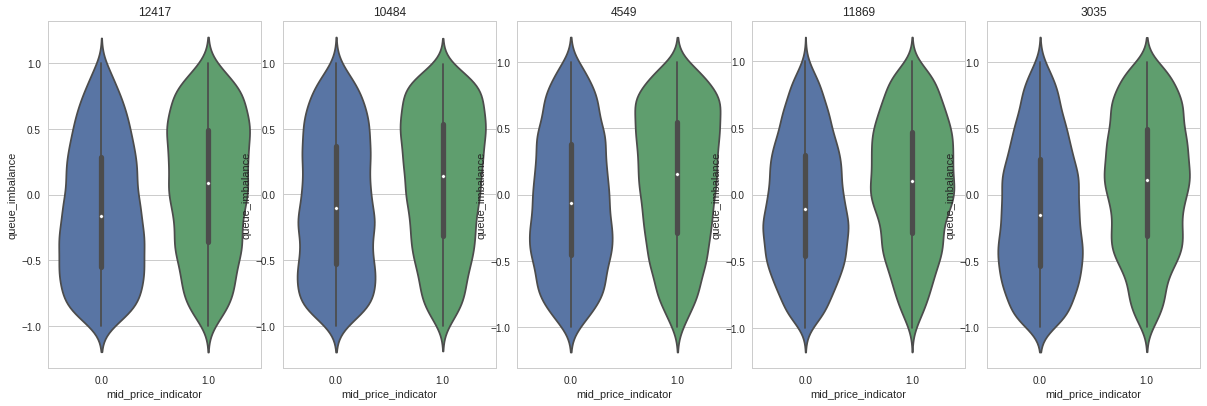

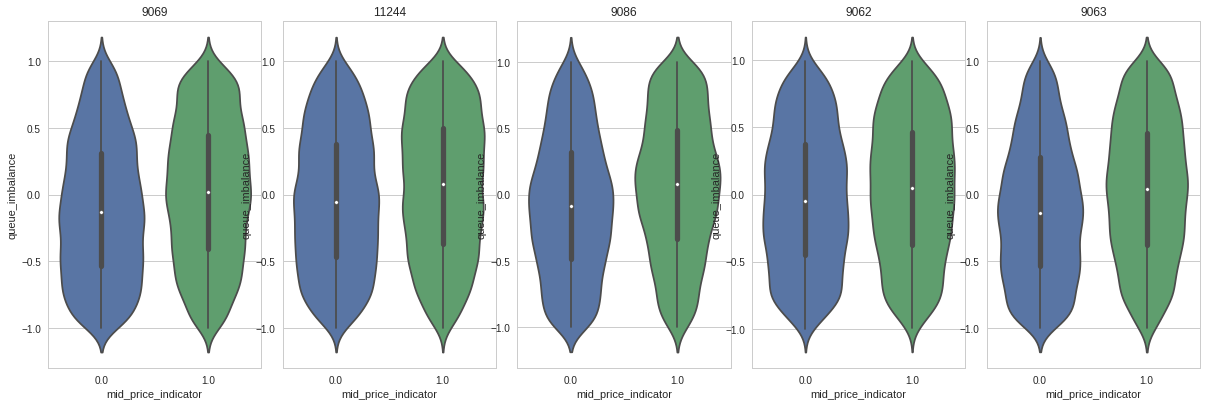

In [20]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

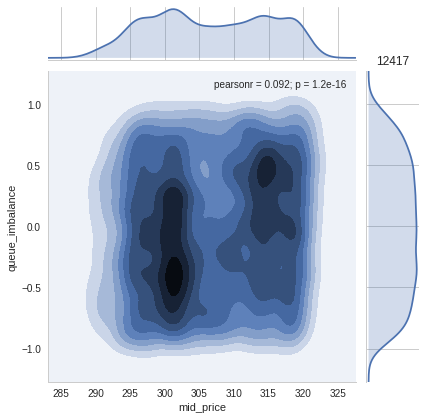

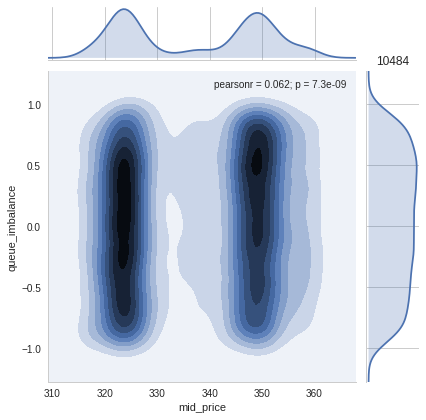

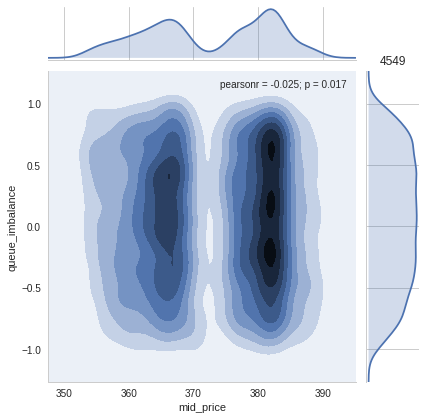

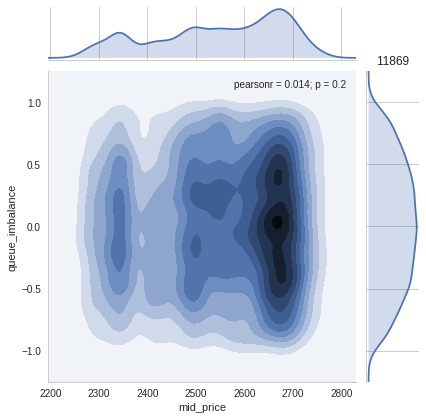

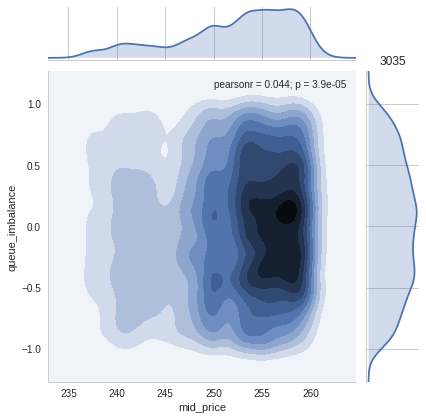

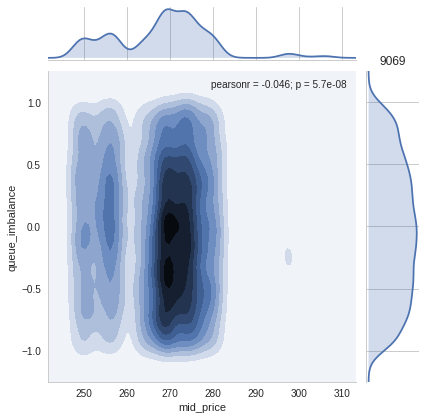

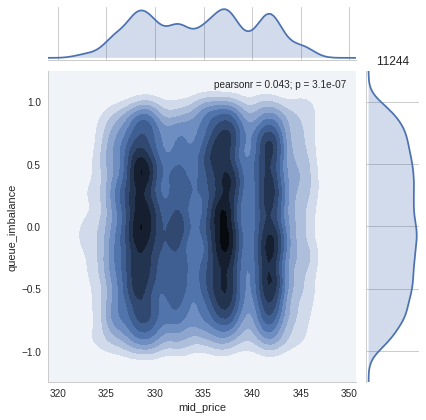

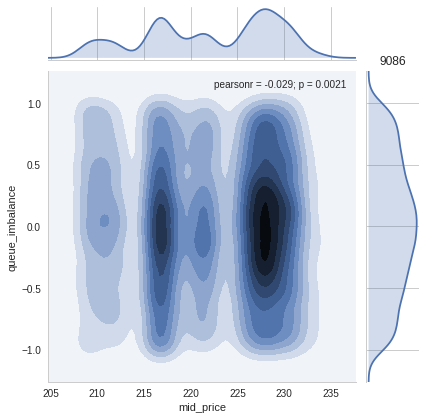

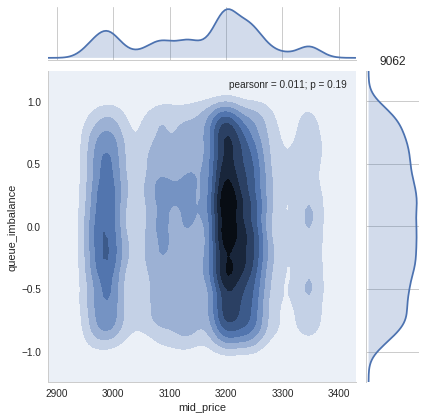

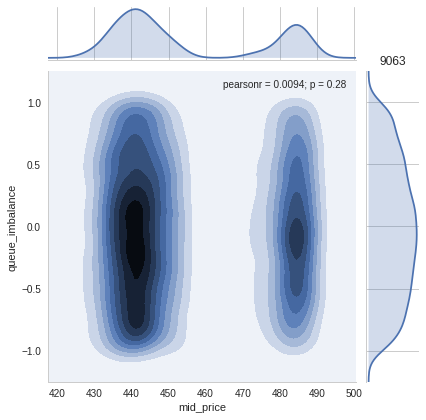

In [21]:
n = 5
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))

plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))
#     sns.jointplot(x="mid_price", y="queue_imbalance", 
#               data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")

Axes(0.125,0.125;0.133621x0.755)
Axes(0.285345,0.125;0.133621x0.755)
Axes(0.44569,0.125;0.133621x0.755)
Axes(0.606034,0.125;0.133621x0.755)
Axes(0.766379,0.125;0.133621x0.755)


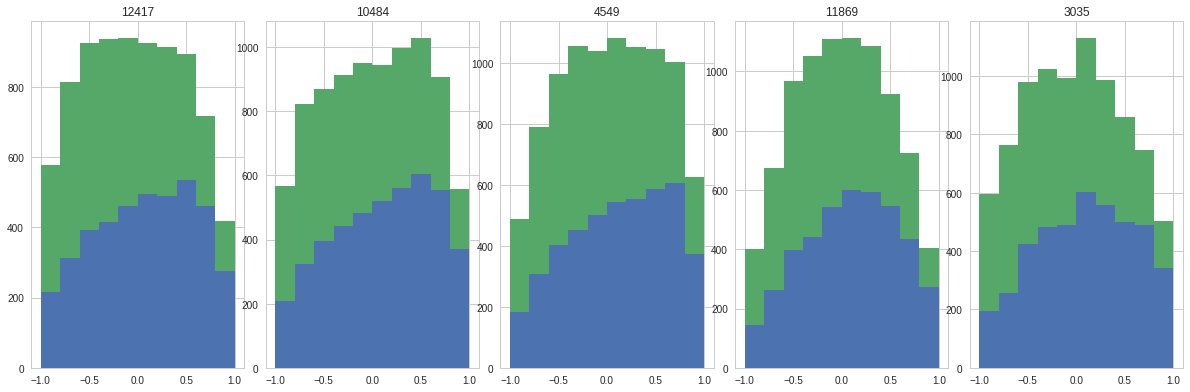

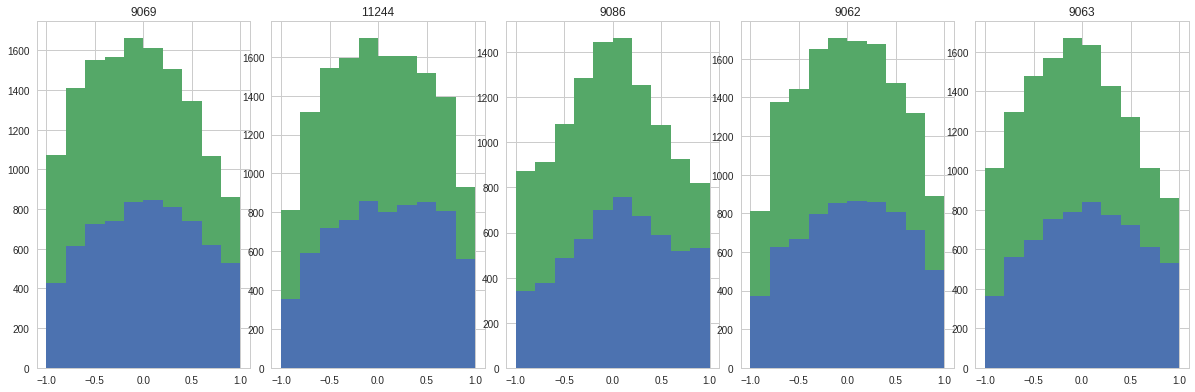

In [22]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    print(axs[i])
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)




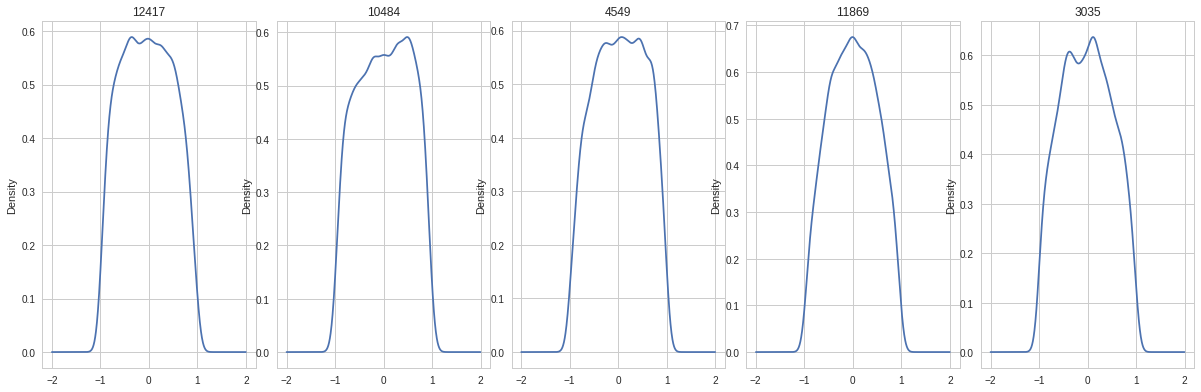

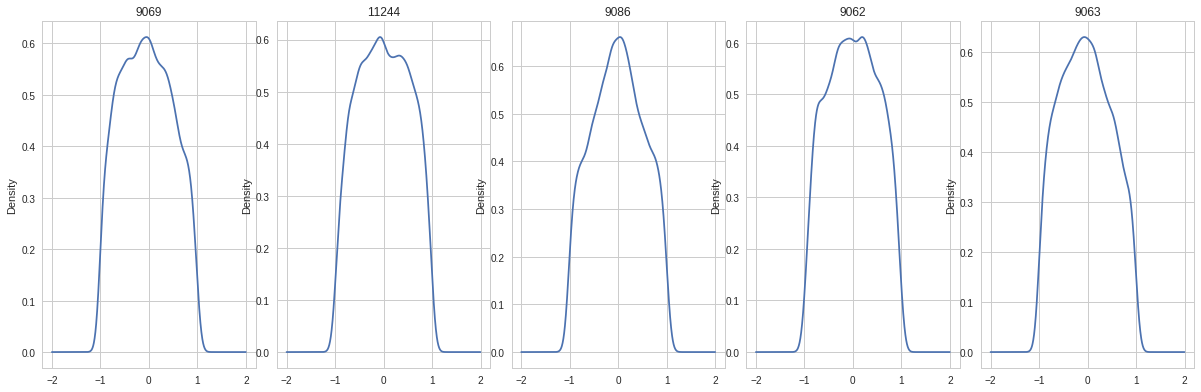

In [25]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

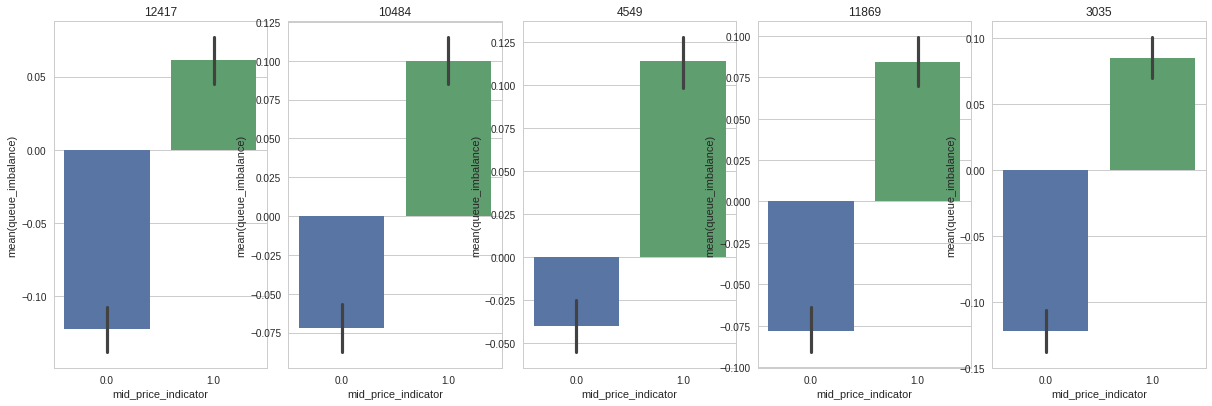

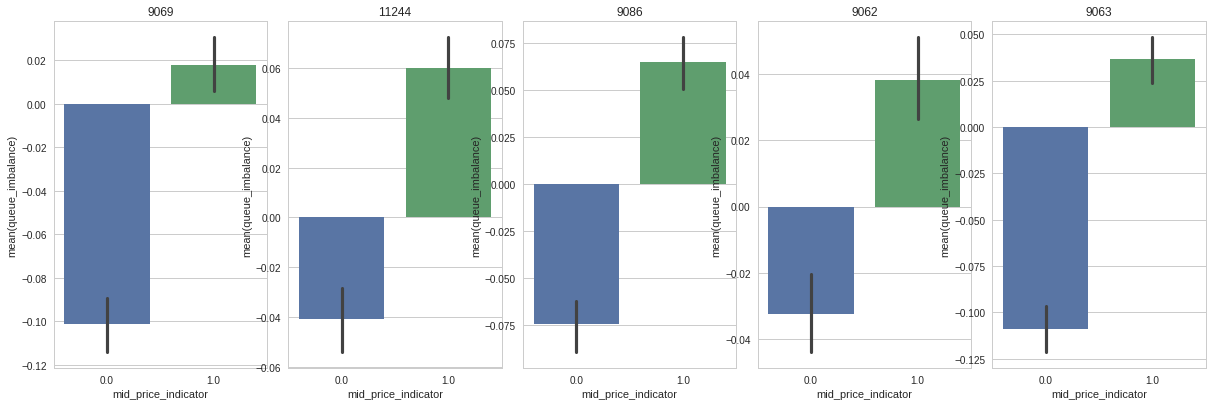

In [24]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

## Clustering data with all features

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(df_summary)

In [29]:
df_summary['class']= kmeans

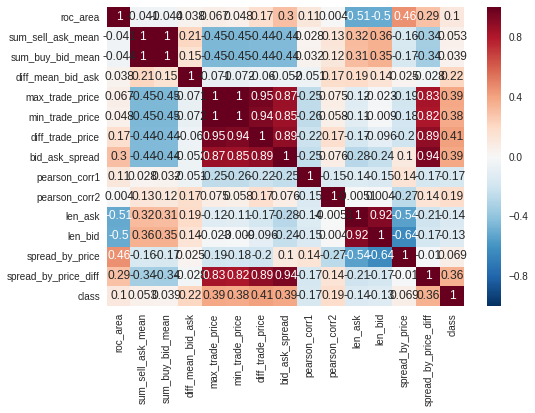

In [30]:
sns.heatmap(df_summary.corr(), annot=True)